# Sensitivity of phase-resolved $\epsilon$ to tilt angles

In [3]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
from scipy import optimize
from scipy.signal import detrend
import statsmodels.api as sm
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import matplotlib.ticker as tck
from roxsi_pyfuns.plotting import multiple_formatter
from datetime import datetime as DT
from cftime import date2num, num2date
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import stats as rps
from roxsi_pyfuns import turbulence as rpt
from roxsi_pyfuns import plotting as rppl

# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/' # For laptop
# rootdir = r'/home/malila/ROXSI/Asilomar2022/SmallScaleArray/' # For PC
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')
figdir = os.path.join(vec_root, 'img')
# Bathymetry
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy_updated_1m.nc')
dsbat = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))



In [4]:
mids = ['C4']
sers = ['17371']
# Tilt angle offsets
roll_offs = np.linspace(-25, 25, 21)
pitch_offs = np.linspace(-25, 25, 21)
# Bursts to skip table
mstr = ''.join(mids) # String joining all mooring IDs 
if mstr == 'C2C3C4':
    fn_skip = os.path.join(rootdir, f'vec_bursts_skip_{mstr}.xlsx')
    dfsk = pd.read_excel(fn_skip, parse_dates=['time'])
# mids = ['C3', 'L1']
# sers = ['17219', '6338']
fs = 16 # Sampling freq
# Define number of sub-segments per wave cycle (should be even)
ncyc = 8
# Minimum R^2 threshold for inertial subrange fits
r2_thresh = 0.9
# Minimum ratio of eddy timescale over advection timescale
eddy_adv_ratio = 5
# Sample period
# t0 = pd.Timestamp('2022-07-14 14:00:00')
t0 = pd.Timestamp('2022-07-12 22:00:00')
# t0 = pd.Timestamp('2022-07-15 00:00:00')
nhours = 1 # No. of hours to process at once
t1 = t0 + pd.Timedelta(hours=nhours)
spd = 60 * 60 * 24 # Seconds per day
# Define expected headings in PCA coordinates for C2, C3 & C4
heading_exp_1 = {'C2': -125, 'C3': -90, 'C4': -90, 'L2': None, 'L1': 160}
# After 2022-07-13 04:00 (C4)
heading_exp_2 = {'C2': -125, 'C3': -90, 'C4': -20, 'L2': None, 'L1': 160}
# Maximum allowable fraction of spikes in vertical vel.
max_spikes_frac = 0.2

# Dataframes for burst-average dissipation and U_rms
time_range = pd.date_range(t0, t1-pd.Timedelta(hours=nhours), freq='1H')
nt = len(time_range)
dfbd = {'{}'.format(m): pd.DataFrame(data={'eps_phase': np.ones(nt)*np.nan, 
                                           'eps_phase_std': np.ones(nt)*np.nan,
                                           'eps_LT83': np.ones(nt)*np.nan,
                                           'U_rms': np.ones(nt)*np.nan,
                                           'depth': np.ones(nt)*np.nan,
                                           },
                                     index=time_range) for m in mids
        }
# Dissipation rates per wave-cycle subsegment
diss_subseg = {'{}'.format(m): {} for m in mids}
U_subseg = {'{}'.format(m): {} for m in mids}
for mid in mids:
    diss_subseg[mid] = {'{}/{}'.format(n, ncyc): [] for n in range(1,ncyc+1)}
    U_subseg[mid] = {'{}/{}'.format(n, ncyc): [] for n in range(1,ncyc+1)}
# Wave-by-wave dissipation rates lists for concatenating dataframes
dfw_list = {'{}'.format(m): [] for m in mids}
# TE01 dissipation rates dict
eps_lt83 = {'{}'.format(m): [] for m in mids}

# Lists for histograms
udu_ratios = {} # U/dU ratios
t_ratios = {} # eddy/adv time scale ratios
for mid in mids:
    udu_ratios[mid] = []
    t_ratios[mid] = []
# List for timestamps of bursts to skip due to too many spikes
skip_list = []

# Define type of fit to use for dissipation rate calculation
fit = 'linear'
# Define number of bins to use for advection speed U (1-4)
nbins = 4
if nbins == 2:
    # Define U ranges for 2 bins
    ubins = [(0, 0.5), (0.5, 2)]
elif nbins == 3:
    # Define U ranges for 3 bins
    ubins = [(0, 0.25), (0.25, 0.5), (0.5, 2)]
elif nbins == 4:
    # Define U ranges for 4 bins
    ubins = [(0, 0.15), (0.15, 0.3), (0.3, 0.45), (0.45, 2)]

# Iterate over requested moorings, figure out which bursts to skip
print('Finding bursts to skip ...')
for mid, ser in zip(mids, sers):
    print('{} - {}'.format(mid, ser))
    # Read netcdf file, check if need to concatenate multiple days
    if ((t1.date() - t0.date()).total_seconds() / spd) > 0:
        # More than one day -> concatenate daily datasets
        drc = pd.date_range(t0.date(), t1.date(), freq='1D') # Range of dates
        dlc = [] # List for concatenating
        for d in drc:
            ncdir = os.path.join(vec_root, mid)
            fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(
                ser, str(d.strftime('%Y%m%d'))))
            dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
            # Append to list
            dlc.append(dsv)
        # Concatenate daily datasets
        dsv = xr.concat(dlc, dim='time')
    else:
        # Only one day
        ncdir = os.path.join(vec_root, mid)
        fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
            str(t0.strftime('%Y%m%d'))))
        dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))

    # Iterate over bursts
    for t0b in time_range:
        t1b = t0b + pd.Timedelta(hours=1)
        if t1b > t1:
            continue
        # Check bursts to skip based on non-stationary tilt angles or spikes
        if mstr == 'C2C3C4' and t0b in dfsk.values:
            # Bad tilt angles in one of the C2/C3/C4 Vectors
            continue
        # Select sample period
        seg = dsv.sel(time=slice(t0b, t1b))
        # Check if too many spikes
        spikes_frac = np.sum(~np.isclose(seg.uz, seg.uzd)) / len(seg.uz)
        if spikes_frac > max_spikes_frac:
            # Too many spikes - skip burst
            print(f'Spike fraction {spikes_frac:.2f} > {max_spikes_frac} -> skipping')
            skip_list.append(t0b) # Append burst start time to skip list

# Main loop to iterate over desired moorings
print('Main loop ...')
for mid, ser in zip(mids, sers):
    print('{} - {}'.format(mid, ser))
    # Read netcdf file, check if need to concatenate multiple days
    if ((t1.date() - t0.date()).total_seconds() / spd) > 0:
        # More than one day -> concatenate daily datasets
        drc = pd.date_range(t0.date(), t1.date(), freq='1D') # Range of dates
        dlc = [] # List for concatenating
        for d in drc:
            ncdir = os.path.join(vec_root, mid)
            fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(
                ser, str(d.strftime('%Y%m%d'))))
            dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
            # Append to list
            dlc.append(dsv)
        # Concatenate daily datasets
        dsv = xr.concat(dlc, dim='time')
    else:
        # Only one day
        ncdir = os.path.join(vec_root, mid)
        fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
            str(t0.strftime('%Y%m%d'))))
        dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
    # Iterate over tilt offset angles (pitch and roll)
    for po in pitch_offs:
        print('pitch offset: {}'.format(po))
        # String for filename
        if po < 0:
            pos = f'm{abs(int(po)):02d}'
        elif po == 0:
            pos = '0'
        else:
            pos = f'p{int(po):02d}'
        for ro in roll_offs:
            # String for filename
            if ro < 0:
                ros = f'm{abs(int(ro)):02d}'
            elif ro == 0:
                ros = '0'
            else:
                ros = f'p{int(ro):02d}'
            # Filename of burst diss. rate csv file (for sensitivity testing)
            csvdir = os.path.join(ncdir, 'dissipation_rate', 'sensitivity_tests')
            if not os.path.isdir(csvdir):
                os.mkdir(csvdir)
            fn_csv_diss = os.path.join(csvdir, 'burst_diss_{}_{}_nhours_{}_ro_{}_po_{}.csv'.format(
                mid, t0.strftime('%Y%m%d_%H%M'), nhours, ros, pos))
            if not os.path.isfile(fn_csv_diss):
                # Wave counter
                wcnt = 0
                # Iterate over bursts
                for t0b in time_range:
                    t1b = t0b + pd.Timedelta(hours=1)
                    if t1b > t1:
                        continue
                    # Check bursts to skip based on non-stationary tilt angles or spikes
                    if mstr == 'C2C3C4' and t0b in dfsk.values:
                        # Bad tilt angles in one of the C2/C3/C4 Vectors
                        continue
                    if t0b in skip_list:
                        # Too many spikes in another Vector burst
                        print(f'Too many spikes in {t0b}')
                        continue
                    # print('{}-{}'.format(t0b, t1b.time()))
                    # Select sample period
                    seg = dsv.sel(time=slice(t0b, t1b))
                    # Get sea-surface elevation (K_rms transform)
                    eta = seg.eta_lin_krms.copy().to_series() # Surface elevation
                    # x vel, despiked
                    uxd = seg.uxd.to_dataframe() # Convert to pandas
                    uxd = uxd.interpolate(method='bfill').interpolate('ffill')
                    uxm = uxd.mean().item()
                    uxd -= uxm
                    # y vel, despiked
                    uyd = seg.uyd.to_dataframe() # Convert to pandas
                    uyd = uyd.interpolate(method='bfill').interpolate('ffill')
                    uym = uyd.mean().item()
                    uyd -= uym
                    # z vel, despiked
                    uzd = seg.uzd.to_dataframe() # Convert to pandas
                    uzd = uzd.interpolate(method='bfill').interpolate('ffill')
                    uzd -= uzd.mean()
                    # Convert velocities to cross-/alongshore
                    if mid in ['C4', 'L1', 'L5', 'C1', 'C6']:
                        # Get correct expected heading for C4
                        if t0b <= pd.Timestamp('2022-07-13 04:00'):
                            he = heading_exp_1[mid]
                        else:
                            he = heading_exp_2[mid]
                        # Rotate velocities to cross/alongshore & vertical using PCA
                        ucs, uls, uw = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                                        uy=uyd.values.squeeze(), 
                                                        uz=uzd.values.squeeze(),
                                                        heading_exp=he, 
                                                        eul1_o=po, eul2_o=ro,
                                                        # print_msg=True,
                                                        )
                    else:
                        # Rotate despiked velocities to East, North, Up
                        vel_arr = np.array([uxd.values.squeeze(), 
                                            uyd.values.squeeze(), 
                                            uzd.values.squeeze()]).T
                        # Add requested pitch/roll offsets to tilt angles
                        enu = rpct.uvw2enu(vel=vel_arr, 
                                        heading=seg['heading_ang'].values, 
                                        pitch=seg['pitch_ang'].values + po, 
                                        roll=seg['roll_ang'].values + ro, 
                                        magdec=12.88,
                                        )
                        # Save variables to dataset
                        uE = enu[0,:].copy()
                        uN = enu[1,:].copy()
                        uw = enu[2,:].copy()
                        dss_seg = rpws.spec_uvz(z=eta.values, u=uE, v=uN, fs=16, )
                        # Rotate horizontal velocities to cross/alongshore
                        angle_met = dss_seg.mdir.item() # Cross-shore angle
                        angle_math = 270 - angle_met # Math angle to rotate
                        if angle_math < 0:
                            angle_math += 360
                        angle_math = np.deg2rad(angle_math) # Radians
                        # Rotate East and North velocities to cross-shore (cs) and 
                        # long-shore (ls)
                        ucs, uls = rpct.rotate_vel(uE, uN, angle_math, )
                    # Estimate U-rms for burst
                    uspec = rpws.spec_uvz(ucs, fs=16, fmerge=5)
                    vspec = rpws.spec_uvz(uls, fs=16, fmerge=5)
                    # Variance of cross- and alongshore orbital velocities
                    m0u = rpws.spec_moment(uspec.Ezz.values, uspec.freq.values, 0)
                    m0v = rpws.spec_moment(vspec.Ezz.values, vspec.freq.values, 0)
                    Urms = np.sqrt(2 * (m0u + m0v))
                    # Mean current
                    Uburst = np.sqrt(uxm**2 + uym**2)
                    # Mean depth
                    h = seg.z_hyd.mean().item()
                    # Estimate full w-spectrum (testing)
                    wspec = rpws.spec_uvz(uw, fs=16, fmerge=5)

                    # Estimate full burst dissipation rate following 
                    # Lumley & Terray (1983) and Trowbridge & Elgar (2001)
                    eps, r2, cf = rpt.dissipation_rate_LT83(f=wspec.freq.values.squeeze(),
                                                            spec=wspec.Ezz.values.squeeze(),
                                                            U=Uburst, sigma=np.sqrt(m0u+m0v),
                                                            skip_f=10)
                    eps_lt83[mid].append(eps)
                    dfbd[mid]['eps_LT83'].loc[t0b] = eps
                    # dfbd83[mid].loc[t0b] = eps

                    # Get zero-crossings, min. 4-sec waves
                    zc, Hw, Hc, Ht = rpzc.get_waveheights(eta.values, method='up', minlen=4*16)
                    nwaves = len(Hw)
                    # Compute H(1/3)
                    Hws = np.sort(Hw) # Sorted wave heights
                    H13 = np.mean(Hws[2*(nwaves//3):]) # Mean of highest 1/3 of waves
                    # Define phase (x) axis to interpolate to
                    n_phase = 160 # Number of points in phase axis
                    min_period = 6 # Min. wave period (sec) to include

                    # Lists for storing dataframes of spectral segments for merging
                    # for different ranges of advection speed U
                    dfsi_lists_1 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
                    dfsi_lists_2 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
                    dfsi_lists_3 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
                    dfsi_lists_4 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
                    dssi = {'q{}'.format(n): [] for n in range(1,ncyc+1)}
                    # Check if spectral datasets saved to netcdf
                    spec_ncdir = os.path.join(ncdir, 'k_specs')
                    if not os.path.isdir(spec_ncdir):
                        os.mkdir(spec_ncdir)
                    csvdir_phase = os.path.join(ncdir, 'phase_res_int')
                    if not os.path.isdir(csvdir_phase):
                        os.mkdir(csvdir_phase)
                    # Interpolate eta, u_cs and w for each wave to wave phase (0-2*pi)
                    for zi,zc0 in enumerate(zc[:-1]):
                        # Only include waves with T > min_period sec
                        Tw = (eta.index[zc[zi+1]] - eta.index[zc[zi]]).total_seconds()
                        if Tw < min_period:
                            continue
                        # Also only include high waves
                        Hwi = Hw[zi]
            #             if Hwi < H13:
            #                 continue
                        # Wave surface elevation, u, v and w for current wave
                        eta_wave = eta.iloc[zc0:zc[zi+1]]
                        u_wave = ucs[zc0:zc[zi+1]]
                        v_wave = uls[zc0:zc[zi+1]]
                        w_wave = uw[zc0:zc[zi+1]]
                        # Surface elevation interpolation
                        df_e = rpzc.interpolate_phase(eta_wave.squeeze(), N=n_phase, 
                                                    label='eta_int_{:04d}'.format(wcnt))
                        # Cross-shore vel. interpolation
                        df_u = rpzc.interpolate_phase(u_wave.squeeze(), N=n_phase, 
                                                    label='u_int_{:04d}'.format(wcnt))
                        # Long-shore vel. interpolation
                        df_v = rpzc.interpolate_phase(v_wave.squeeze(), N=n_phase, 
                                                    label='u_int_{:04d}'.format(wcnt))
                        # Vertical vel. interpolation
                        df_w = rpzc.interpolate_phase(w_wave.squeeze(), N=n_phase, 
                                                    label='u_int_{:04d}'.format(wcnt))
                        # Also make df of non-interpolated vert. vel. with phase axis
                        phase_ni = np.linspace(0, 1, len(w_wave)) #* 2*np.pi # non-int. phases
                        df_wni = pd.DataFrame(data=w_wave.squeeze(), index=phase_ni)
                        # Increase wave counter
                        wcnt += 1

                        # Estimate spectra for 1/ncyc wave cycles
                        nsub = n_phase // ncyc # no. of samples per phase sub-segment
                        nsub_ni = len(phase_ni) // ncyc # non-interpolated # of samples
                        # Frequencies
                        n_freqs = int(np.floor(nsub / 2 )) # No. of frequency bands
                        n_freqs_ni = int(np.floor(nsub_ni / 2 )) # No. of frequency bands
                        # Wavenumbers to interpolate spectrum to
                        n_int = 30 # Number of wavenumbers to interpolate to
                        kmin = (2*np.pi) / 0.5 # Min. interpolation wavenumber
                        kmax = (2*np.pi) / 0.05 # Max. interpolation wavenumber
                        ki = np.linspace(kmin, kmax, n_int) # Interp. target k's
                        # Initialize dict to store spectral dataframes (incl. U)
                        dfsi = {} # k-spec dataframes
                        for nb in range(1, nbins+1):
                            dfsi['{}'.format(nb)] = {}
                        for i in range(ncyc):
                            # Get short-segment interpolated velocities
                            useg = df_u.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                            vseg = df_v.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                            wseg = df_w.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                            # Also get non-interpolated vertical velocity segment
                            wseg_ni = df_wni.iloc[i*nsub_ni:(i+1)*nsub_ni].values.squeeze()
                            # Timestamp
                            t0seg = (pd.Timestamp(eta_wave.index[0]) + 
                                    pd.Timedelta(seconds=(Tw/n_int)*(i/ncyc)))
                            # Compute mean current and check that U >> dU for segment
                            U = np.sqrt(np.mean(useg)**2 + np.mean(vseg)**2).item() # Mean orb. vel. mag.
                            umag = np.sqrt(useg**2 + vseg**2) # Orb. vel. magnitude, not mean
                            dU = np.std(umag) # Variability in umag (following George et al., 1994)
                            # Append U / dU ratio to list for histogram
                            udu_ratios[mid].append(U / dU)
                            # Check U/dU ratio
                            if (U / dU) < 1:
                                # U vs. dU ratio (Eq (6) of George et al., 1994) too small
                                # Use U / dU = 1 as threshold following Rosman & Gerbi (2017), 
                                # Fig. 9
                                continue
                            # Check that the turnover timescale of the eddies is much longer 
                            # than the time for advection of the eddies past the sensor.
                            # First estimate k spectrum of w following George et al. (1994)
                            dsk_i = rpt.k_spec_wavephase(w=wseg_ni, U=U)
                            # Check highest allowable k based on sampling rate and volume
                            maxk_check = np.min((kmax, np.pi*fs/U))
                            # Set to NaN all spectral elements with k > maxk
                            dsk_i.k_spec.values = dsk_i.k_spec.where(dsk_i.k < maxk_check).values
                            # Make (noisy) first estimate of dissipation rate from single
                            # spectrum for eddy time scale
                            rs_list = [] # R^2 values of fits
                            eps_list = [] # Dissipation rate estimates from fits
                            si_list = [] # Start indices of fits (to get lowest k of best fit)
                            sis = np.arange(1, n_freqs_ni//2) # Start indices of -5/3 fit
                            eis = -np.arange(1, n_freqs_ni//2)[::-1] # End indices of fit
                            # Iterate over different k ranges and fit inertial subrange
                            for si in sis:
                                for ei in eis:
                                    N = len(dsk_i.k.values[si:ei])
                                    if N < n_freqs_ni // 2:
                                        # Don't try to fit to less than half of 
                                        # available points
                                        continue
                                    elif N < 5:
                                        # Don't fit to less than 5 data points
                                        continue
                                    # No NaNs allowed
                                    if np.any(np.isnan(dsk_i.k_spec.values.squeeze()[si:ei])):
                                        continue
                                    # Get diss. rate and R^2 of inertial subrange fit to 
                                    # spectrum segment
                                    epsilon, r_squared, coeff = rpt.dissipation_rate(
                                        k=dsk_i.k.values[si:ei], 
                                        spec=dsk_i.k_spec.values.squeeze()[si:ei], 
                                        fit=fit)
                                    # Save R^2 and epsilon to dict
                                    rs_list.append(r_squared)
                                    eps_list.append(epsilon)
                                    si_list.append(si)
                            # Find best fit from R^2 (highest) and fit length (longest)
                            if len(rs_list) == 0:
                                # No fits were made (too many NaNs)
                                continue
                            # Get index of max. R^2
                            max_rsq_ind = np.argmax(rs_list)
                            # Use dissipation rate estimate with highest R^2 value
                            eps_est = eps_list[max_rsq_ind]
                            # Use lowest k included in the best fit
                            sim = si_list[max_rsq_ind]
                            l = 2*np.pi / dsk_i.k.values[sim]
                            # Compute eddy time scale (Eq. 6.11 of Pope, pg. 187)
                            t_eddy = (l**2 / eps_est)**(1/3)
                            # Compute advection time scale
                            t_adv = l / U
                            t_ratios[mid].append(t_eddy / t_adv)
                            # Check t_eddy vs. t_adv criterion, only save spectrum
                            # for later ensemble averaging if ratio high enough
                            if (t_eddy / t_adv) < eddy_adv_ratio:
                                # Ratio too low -> don't save spectrum
                                continue
                            # Estimate new k-spectrum and interpolate to pre-defined k axis
                            dsk = rpt.k_spec_wavephase(w=wseg_ni, U=U, k_int=ki)
                            # Add wave height and wave counter as variable
                            dsk['Hw'] = ([], Hwi)
                            dsk['wcnt'] = ([], wcnt)
                            # Add time coordinate to spectrum dataset
                            dsk = dsk.assign_coords(time=[t0seg])
                            # Check highest allowable k
                            maxk = np.min((2*np.pi/0.05, np.pi*fs/U))
                            # Set to NaN all spectral elements with k > maxk
                            dsk.k_spec.values = dsk.k_spec.where(dsk.k < maxk).values
                            # Append to list
                            dssi['q{}'.format(i+1)].append(dsk)

                    # Concatenate spectral datasets and save to netcdf
                    dss = {} # Datasets to concatenate
                    for n in range(1, ncyc+1):
                        if len(dssi['q{}'.format(n)]) > 0:
                            dss['q{}'.format(n)] = xr.concat(
                                    dssi['q{}'.format(n)], dim='time')

                    # Dicts to store curve fit coeff.
                    rsqs = {} # R^2 value for best fit
                    coeffs = {} # Fit coefficient for best fit
                    sid = {} # Optimal start index for fit
                    eid = {} # Optimal end index for fit
                    diss_rate = {}
                    U_diss = {}
                    # Iterate over sub-sections
                    for n in range(1, ncyc+1):
                        # Iterate over U ranges defined by nbins
                        for ui in range(nbins):
                            # Select correct dataset
                            if f'q{n}' in dss.keys():
                                dsi = dss['q{}'.format(n)].copy()
                                # Select correct U range if using more than 1 U bin
                                if nbins > 1:
                                    dsi = dsi.isel(
                                        time=np.logical_and(
                                            dsi.U>=ubins[ui][0], dsi.U<ubins[ui][1]))
                                    # Check that the selected U range has data
                                    if len(dsi.time) == 0:
                                        continue
                                # Average spectra for wavenumbers with no more than maxnan 
                                # fraction of NaN values
                                maxnan = 0.2 # Max. allowed fraction of NaNs per wavenumber
                                good_inds = (dsi.k_spec.isnull().sum(dim='time')/len(dsi.time)<=maxnan)
                                ps_mean = dsi.where(good_inds).mean(dim='time').k_spec.values
                                # Also get corresponding U values
                                U_mean = dsi.where(good_inds).U.mean(dim=['k', 'time']).item()
                                # Lists to store curve fit coeff.
                                rsqs_i = [] # R^2 value for best fit
                                coeffs_i = [] # R^2 value for best fit
                                sid_i = [] # Optimal start index for fit
                                eid_i = [] # Optimal end index for fit
                                npts = [] # Number of points to fit
                                diss_i = [] # Dissipation rates
                                U_i = [] # rms velocities
                                # Iterate over different start/end freq. indices for fit
                                # Disregard first (0-th) wavenumber
                                sis = np.arange(1, n_int//2) # Start indices of fits
                                eis = -np.arange(1, n_int//2)[::-1] # End inds of fits
                                for si in sis:
                                    for ei in eis:
                                        N = len(ki[si:ei])
                                        if N < n_int // 2:
                                            # Don't try to fit to less than half of 
                                            # available points
                                            continue
                                        # No NaNs allowed
                                        if np.any(np.isnan(ps_mean[si:ei])):
                                            continue
                                        # Get diss. rate and R^2 of inertial subrange fit to 
                                        # spectrum segment
                                        epsilon, r_squared, coeff = rpt.dissipation_rate(
                                            k=ki[si:ei], spec=ps_mean[si:ei], fit=fit)
                                        # Save to dict if R^2 high enough
                                        if r_squared >= r2_thresh:
                                            rsqs_i.append(r_squared)
                                            coeffs_i.append(coeff)
                                            diss_i.append(epsilon)
                                            sid_i.append(si)
                                            eid_i.append(ei)
                                            npts.append(N)
                                            U_i.append(U_mean)
                                # Find best fit from R^2 (highest) and fit length (longest)
                                if len(rsqs_i) == 0:
                                    # No fits were made (too many NaNs)
                                    continue
                                max_rsq_ind = np.argmax(rsqs_i)
                                # Save parameters corresponding to max R^2
                                diss_rate['q{}'.format(n)] = diss_i[max_rsq_ind]
                                rsqs['q{}'.format(n)] = rsqs_i[max_rsq_ind]
                                coeffs['q{}'.format(n)] = coeffs_i[max_rsq_ind]
                                U_diss['q{}'.format(n)] = U_i[max_rsq_ind]
                                sid['q{}'.format(n)] = sid_i[max_rsq_ind]
                                eid['q{}'.format(n)] = eid_i[max_rsq_ind]
                                # Also append to ensemble-avg list
                                diss_subseg[mid]['{}/{}'.format(n, ncyc)].append(
                                    diss_i[max_rsq_ind])
                                U_subseg[mid]['{}/{}'.format(n, ncyc)].append(
                                    U_i[max_rsq_ind])
                            else:
                                # Data not good enough for any dissipation rate estimates
                                diss_rate['q{}'.format(n)] = np.nan
                                rsqs['q{}'.format(n)] = np.nan
                                coeffs['q{}'.format(n)] = np.nan
                                U_diss['q{}'.format(n)] = np.nan
                                # Also append to ensemble-avg list
                                diss_subseg[mid]['{}/{}'.format(n, ncyc)].append(np.nan)
                                U_subseg[mid]['{}/{}'.format(n, ncyc)].append(np.nan)

                    # Save burst-average dissipation and U_rms
                    dfbd[mid]['eps_phase'].loc[t0b] = np.array(list(diss_rate.values())).mean()
                    dfbd[mid]['eps_phase_std'].loc[t0b] = np.array(list(
                        diss_rate.values())).std()
                    dfbd[mid]['U_rms'].loc[t0b] = Urms
                    dfbd[mid]['depth'].loc[t0b] = h
                    # dfbu[mid].loc[t0b] = Urms / h
                # Save to csv
                dfbd[mid].index = dfbd[mid].index.rename('time')
                dfbd[mid].to_csv(fn_csv_diss)
            else:
                dfbd[mid] = pd.read_csv(fn_csv_diss, parse_dates=['time']).set_index('time')

print('Done.')


Finding bursts to skip ...
C4 - 17371
Main loop ...
C4 - 17371
pitch offset: -25.0


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)


pitch offset: -22.5


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in l

pitch offset: -20.0


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in l

pitch offset: -17.5


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in l

pitch offset: -15.0


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)


pitch offset: -12.5


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)


pitch offset: -10.0


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)


pitch offset: -7.5


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)


pitch offset: -5.0


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)


pitch offset: -2.5


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)


pitch offset: 0.0


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)


pitch offset: 2.5


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)


pitch offset: 5.0


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)


pitch offset: 7.5
pitch offset: 10.0
pitch offset: 12.5
pitch offset: 15.0
pitch offset: 17.5
pitch offset: 20.0
pitch offset: 22.5
pitch offset: 25.0
Done.


In [5]:
# Combine all dissipation estimates by tilt angle into xr.Datasets
# Note: Run previous cell first...
pitch_offs = np.linspace(-25, 25, 21)
npo = len(pitch_offs)
roll_offs = np.linspace(-25, 25, 21)
nro = len(roll_offs)
dseps = xr.Dataset(data_vars=dict(
                       eps_ps=(['pitch_offset', 'roll_offset'], np.zeros((npo,nro))),
                       eps_lt83=(['pitch_offset', 'roll_offset'], np.zeros((npo,nro))),
                   ),
                   coords=dict(
                       pitch_offset=(["pitch_offset"], pitch_offs),
                       roll_offset=(["roll_offset"], roll_offs),
                   ),
                   )
# Get reference dissipation rate (no tilt offsets)
fn_csv_diss = os.path.join(csvdir, 'burst_diss_{}_{}_nhours_{}_ro_0_po_0.csv'.format(
    mid, t0.strftime('%Y%m%d_%H%M'), nhours))
dfeps = pd.read_csv(fn_csv_diss, parse_dates=['time']).set_index('time')
eps_ref_ps = dfeps['eps_phase'].values.squeeze().copy()
eps_ref_lt83 = dfeps['eps_LT83'].values.squeeze().copy()

# Iterate over tilt angle offsets, read data and populate dataset
for po in pitch_offs:
    # String for filename
    if po < 0:
        pos = f'm{abs(int(po)):02d}'
    elif po == 0:
        pos = '0'
    else:
        pos = f'p{int(po):02d}'
    for ro in roll_offs:
        # String for filename
        if ro < 0:
            ros = f'm{abs(int(ro)):02d}'
        elif ro == 0:
            ros = '0'
        else:
            ros = f'p{int(ro):02d}'
        # Filename of burst diss. rate csv file (for sensitivity testing)
        csvdir = os.path.join(ncdir, 'dissipation_rate', 'sensitivity_tests')
        fn_csv_diss = os.path.join(csvdir, 'burst_diss_{}_{}_nhours_{}_ro_{}_po_{}.csv'.format(
            mid, t0.strftime('%Y%m%d_%H%M'), nhours, ros, pos))
        dfeps = pd.read_csv(fn_csv_diss, parse_dates=['time']).set_index('time')
        # Populate dataset with ratios of epsilon / eps_ref
        eps_ratio_ps = dfeps['eps_phase'].values.squeeze() / eps_ref_ps
        dseps.eps_ps.loc[dict(pitch_offset=po, roll_offset=ro)] = eps_ratio_ps
        # Same for LT83 epsilon
        eps_ratio_lt83 = dfeps['eps_phase'].values.squeeze() / eps_ref_lt83
        dseps.eps_lt83.loc[dict(pitch_offset=po, roll_offset=ro)] = eps_ratio_lt83

# Plot
fig, axes = plt.subplots(figsize=(8,4), ncols=2, sharey=True)
# cs = dseps.eps_ps.plot.contourf(ax=ax, locator=ticker.LogLocator(), cmap=cm.PuBu_r, 
#                                 add_colorbar=False)
# levels = np.geomspace(0.5, 10, 10)
# levels = np.linspace(0, 8, 33)
levels = np.linspace(0, 7, 29)
# levels = np.concatenate([np.linspace(0.5, 0.875, 4), np.linspace(1, 10, 7)])
cs1 = axes[0].contourf(dseps.roll_offset, dseps.pitch_offset, dseps.eps_ps,
                       cmap='RdBu_r', levels=levels, norm=colors.TwoSlopeNorm(1))
axes[0].set_ylabel('Pitch offset (deg)')
axes[0].set_xlabel('Roll offset (deg)')
axes[0].set_title(r'Phase-resolved $\epsilon$')
# LT83 on right
cs2 = axes[1].contourf(dseps.roll_offset, dseps.pitch_offset, dseps.eps_lt83,
                       cmap='RdBu_r', levels=levels, norm=colors.TwoSlopeNorm(1))
axes[1].set_xlabel('Roll offset (deg)')
axes[1].set_title(r'LT83 $\epsilon$')
cax = axes[1].inset_axes([1.02, 0.0, 0.03, 1.0])
fig.colorbar(cs2, ax=axes[1], cax=cax, label=r'$\epsilon / \epsilon_\mathrm{ref}$')

# Save/show figure
plt.tight_layout()
fn_fig = os.path.join(figdir, 'epsilon_tilt_sensitivity_{}_{}.png'.format(
    mid, t0.strftime('%Y%m%d_%H%M')))
if not os.path.isfile(fn_fig):
    plt.savefig(fn_fig, bbox_inches='tight', dpi=300)
    plt.close()
else:
    plt.show()

print('Done.')

FileNotFoundError: [Errno 2] No such file or directory: '/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/Vectors/Level1/C4/dissipation_rate/sensitivity_tests/burst_diss_C4_20220712_2200_nhours_1_ro_m24_po_m25.csv'

L1 - 6338
2022-07-13 04:00:00
Flipping vertical velocity ... 
ucs-uw phase at max coh: -79.97
eul1: -179.89, eul2: -1.41, eul3: -166.18
 


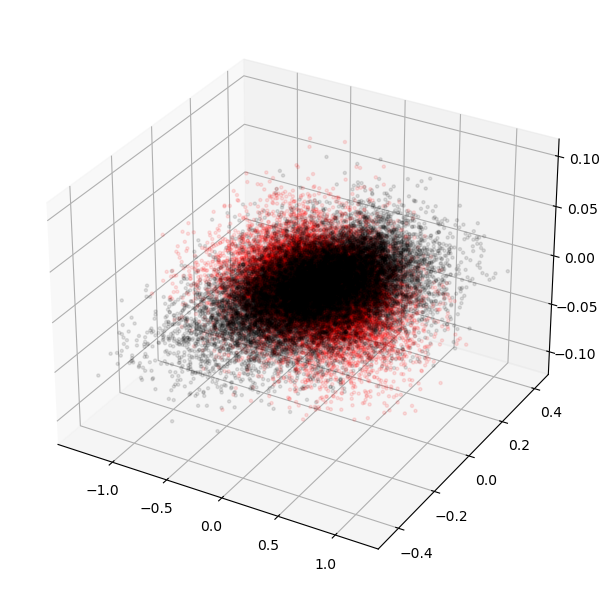

In [5]:
mid = 'L1'
ser = '6338'
# mid = 'C4'
# ser = '17371'
# mid = 'C3'
# ser = '17219'
# mid = 'C2'
# ser = '17212'
heading_exp_1 = {'C2': -125, 'C3': -90, 'C4': 0, 'L2': None, 'L1': -160}
heading_exp_2 = {'C2': -125, 'C3': -90, 'C4': 0, 'L2': None, 'L1': -160}
t0 = pd.Timestamp('2022-07-13 04:00')
t1 = t0 + pd.Timedelta(hours=1)
spd = 60 * 60 * 24 # Seconds per day
time_range = pd.date_range(t0, t1, freq='1H') # Time index

print('{} - {}'.format(mid, ser))
# Read netcdf file, check if need to concatenate multiple days
if ((t1.date() - t0.date()).total_seconds() / spd) > 0:
    # More than one day -> concatenate daily datasets
    drc = pd.date_range(t0.date(), t1.date(), freq='1D') # Range of dates
    dlc = [] # List for concatenating
    for d in drc:
        ncdir = os.path.join(vec_root, mid)
        fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(
            ser, str(d.strftime('%Y%m%d'))))
        dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
        # Append to list
        dlc.append(dsv)
    # Concatenate daily datasets
    dsv = xr.concat(dlc, dim='time')
else:
    # Only one day
    ncdir = os.path.join(vec_root, mid)
    fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
        str(t0.strftime('%Y%m%d'))))
    dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))

# Iterate over bursts
for t0b in time_range:
    t1b = t0b + pd.Timedelta(hours=1)
    if t1b > t1:
        continue
    print(t0b)
    # print('{}-{}'.format(t0b, t1b.time()))
    # Select sample period
    seg = dsv.sel(time=slice(t0b, t1b))
    # Get sea-surface elevation (K_rms transform)
    eta = seg.eta_lin_krms.copy().to_series() # Surface elevation
    time = seg.time.values # time axis (for t-s plot)

    # Convert velocities to cross-/alongshore
    # x vel, despiked
    uxd = seg.uxd.to_dataframe() # Convert to pandas
    uxd = uxd.interpolate(method='bfill').interpolate('ffill')
    uxm = uxd.mean().item()
    uxd -= uxm
    # y vel, despiked
    uyd = seg.uyd.to_dataframe() # Convert to pandas
    uyd = uyd.interpolate(method='bfill').interpolate('ffill')
    uym = uyd.mean().item()
    uyd -= uym
    # z vel, despiked
    uzd = seg.uzd.to_dataframe() # Convert to pandas
    uzd = uzd.interpolate(method='bfill').interpolate('ffill')
    uzd -= uzd.mean()
    # Get correct expected eul3 angle for C4 
    if t0b <= pd.Timestamp('2022-07-13 04:00'):
        # Before C4 rotated
        he = heading_exp_1[mid]
    else:
        # After C4 heading rotated by 60 deg
        he = heading_exp_2[mid]
    # Rotate velocities to cross/alongshore & vertical using PCA
    ucs, uls, uw, eul = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                            uy=uyd.values.squeeze(), 
                                            uz=uzd.values.squeeze(),
                                            heading_exp=he, 
                                            print_msg=True,
                                            return_eul=True,
                                            )
    print('eul1: {:.2f}, eul2: {:.2f}, eul3: {:.2f}'.format(
        np.rad2deg(eul['eul1']), np.rad2deg(eul['eul2']), np.rad2deg(eul['eul3'])))
    print(' ')

# Plot unrotated vs. rotated velocities
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={"projection": "3d"})
ax.scatter(uxd, uyd, uzd, color='k', alpha=0.1, marker='.')
ax.scatter(ucs, uls, uw, color='r', alpha=0.1, marker='.')
# axes[0].scatter(uxd, uyd, uzd, color='k', alpha=0.1)
# axes[0].set_xlabel('x')
# axes[0].set_ylabel('y')
# axes[0].set_zlabel('z')
# axes[1].scatter(ucs, uls, uw, color='k', alpha=0.1)
# axes[1].set_xlabel('cross-shore')
# axes[1].set_ylabel('along-shore')
# axes[1].set_zlabel('vertical')

plt.tight_layout()
plt.show()